In [1]:
%pip install lifelines
%pip install torch --upgrade

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 4.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=59b365e3eb6e12ee175dcc55c3076628d7411c094326ed77bf1ebc282c69c14e
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 130.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [2]:
# ============================================================
# FAST: Fair Survival Time Prediction via Mutual Information Minimization
# ============================================================
from google.colab import drive
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import torch, numpy as np, random, os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/STA497/code test/data/data_I.csv'
SEED = 666

Using device: cpu
Mounted at /content/drive


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

# ============================================================
# 2. Dataset class
# ============================================================

class SurvDataset(Dataset):
    def __init__(self, df, feature_cols):
        self.x = torch.tensor(df[feature_cols].values, dtype=torch.float32)
        self.a = torch.tensor(df["A"].values, dtype=torch.float32).view(-1,1)
        self.o = torch.tensor(df["Y"].values, dtype=torch.float32).view(-1,1)
        self.d = torch.tensor(df["Delta"].values, dtype=torch.float32).view(-1,1)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.a[i], self.o[i], self.d[i]


# ============================================================
# 3. Baseline Weibull fit (λ, ρ)
# ============================================================

class WeibullMLE(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_lambda = nn.Parameter(torch.tensor([0.0]))
        self.log_rho = nn.Parameter(torch.tensor([0.0]))
    def forward(self):
        return torch.exp(self.log_lambda), torch.exp(self.log_rho)

def nll_weibull(o, d, lam, rho):
    eps = 1e-8
    t_l = (o/lam).clamp(min=eps)
    log_lambda0 = torch.log(rho+eps)-torch.log(lam+eps)+(rho-1)*torch.log(t_l+eps)
    cumhaz = t_l**rho
    return -(d*log_lambda0 - cumhaz).mean()

def fit_baseline(o, d, lr=0.05, steps=1000):
    model = WeibullMLE()
    opt = optim.Adam(model.parameters(), lr=lr)
    for t in range(steps):
        lam, rho = model()
        loss = nll_weibull(o, d, lam, rho)
        opt.zero_grad(); loss.backward(); opt.step()
    with torch.no_grad():
      lam, rho = model()
    return lam.detach(), rho.detach()

# ============================================================
# 4. Survival model f_θ(x)
# ============================================================

class LogHazardNet(nn.Module):
    def __init__(self, in_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x)

def nll_full_weibull(fx, o, d, lam, rho):
    eps = 1e-8
    if not torch.is_tensor(lam):
        lam = torch.tensor(lam, dtype=torch.float32, device=fx.device)
    if not torch.is_tensor(rho):
        rho = torch.tensor(rho, dtype=torch.float32, device=fx.device)

    t_l = (o / lam).clamp(min=eps)
    log_lambda0 = torch.log(rho + eps) - torch.log(lam + eps) + (rho - 1) * torch.log(t_l + eps)
    cumhaz = (t_l ** rho) * torch.exp(fx)
    return -(d * (log_lambda0 + fx) - cumhaz).mean()

# ============================================================
# 5. MINE estimator for I(A,T)
# ============================================================

class MINE(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.scorer = nn.Sequential(
            nn.Linear(2, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1, bias=False)
        )
        self.register_buffer("ema_log_mexp", torch.tensor(0.0))
        self.ema_alpha = 0.001

    def forward(self, a, tau):
        return self.scorer(torch.cat([a, tau], dim=1))

    def dv(self, a_joint, tau_joint, a_marg, tau_marg, update_ema: bool = True):
        psi_j = self.forward(a_joint, tau_joint)
        psi_m = self.forward(a_marg,  tau_marg)

        # 统一居中：用同一个常数 c
        c = torch.cat([psi_j, psi_m], dim=0).mean()
        psi_j = (psi_j - c).clamp(-10, 10)
        psi_m = (psi_m - c).clamp(-10, 10)

        term1 = psi_j.mean()

        # log-mean-exp trick
        m = psi_m.max()
        log_mexp = m + torch.log(torch.mean(torch.exp(psi_m - m)) + 1e-12)

        if update_ema:
            with torch.no_grad():
                if self.ema_log_mexp.item() == 0:
                    self.ema_log_mexp.copy_(log_mexp)
                else:
                    self.ema_log_mexp.copy_((1 - self.ema_alpha) * self.ema_log_mexp +
                                            self.ema_alpha * log_mexp)

        I_tilde = term1 - self.ema_log_mexp
        I_tilde = torch.nan_to_num(I_tilde, nan=0.0, posinf=0.0, neginf=0.0)
        return I_tilde

def sample_T(fx, lam, rho):
    u = torch.rand_like(fx).clamp(1e-6,1-1e-6)
    scale = lam*torch.exp(-fx/rho)
    return scale*(-torch.log(1-u))**(1/rho)

# ============================================================
# 6. FAST training loop
# ============================================================

def train_FAST(train_ds, lam, rho, gamma=0.1, epochs=40, batch=128, lr_theta=1e-3, lr_omega=1e-4, seed=SEED, K_omega=1):
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    loader = DataLoader(train_ds, batch_size=batch, shuffle=True, drop_last=True, generator=g)

    fnet = LogHazardNet(train_ds.x.shape[1]).to(device)
    mine = MINE().to(device)
    opt_theta = optim.Adam(fnet.parameters(), lr=lr_theta)
    opt_omega = optim.Adam(mine.parameters(), lr=lr_omega)
    nll_hist, mi_hist = [], []

    for ep in range(1, epochs+1):
        # 固定随机种子（兼容旧版本）
        torch.manual_seed(seed + ep)
        epoch_nll, epoch_I, nb = 0.0, 0.0, 0

        for x,a,o,d in loader:
            x,a,o,d = x.to(device),a.to(device),o.to(device),d.to(device)
            fx = fnet(x)

            # ---------------- ω-step: 只更新 MINE（让 tau 对 θ 不可导） ----------------
            # 可选：多步 ω 更新以稳定 Ĩ
            for _ in range(K_omega):
                with torch.no_grad():
                    fx_det = fnet(x)                 # 不需要 θ 的梯度
                tau_det = sample_T(fx_det.detach(), lam, rho)  # 关键：detach，切断 θ 梯度
                idx = torch.randperm(a.size(0))
                a_shuf = a[idx]

                I_tilde_w = mine.dv(a, tau_det, a_shuf, tau_det)
                loss_omega = -I_tilde_w
                opt_omega.zero_grad()
                loss_omega.backward()
                torch.nn.utils.clip_grad_norm_(mine.parameters(), 1.0)  # 稳定起见
                opt_omega.step()

            # ---------------- θ-step: 只更新主网络（tau 必须可导；冻结 ω） ----------------
            for p in mine.parameters(): p.requires_grad = False  # 冻结 ω
            fx = fnet(x)
            nll = nll_full_weibull(fx, o, d, lam, rho)

            tau = sample_T(fx, lam, rho)            # 关键：不要 no_grad / detach
            idx = torch.randperm(a.size(0))
            a_shuf = a[idx]

            I_tilde = mine.dv(a, tau, a_shuf, tau)  # 现在 ∇θ Ĩ ≠ 0
            loss_theta = nll - gamma * I_tilde

            opt_theta.zero_grad()
            loss_theta.backward()
            opt_theta.step()
            for p in mine.parameters(): p.requires_grad = True   # 解冻 ω

            # ---- 统计 epoch 平均 ----
            epoch_nll += nll.item()
            epoch_I   += I_tilde.item()
            nb += 1

        nll_hist.append(epoch_nll / nb)
        mi_hist.append(epoch_I / nb)
        print(f"[epoch {ep}] NLL={nll_hist[-1]:.4f}, I~={mi_hist[-1]:.4f}")

    plt.plot(nll_hist, label="NLL"); plt.plot(mi_hist, label="I~")
    plt.legend(); plt.xlabel("Epoch"); plt.title(f"Training (γ={gamma})")
    plt.show()

    return fnet, mine

# ============================================================
# 7. Evaluation Metrics
# ============================================================

def predict_risk(fnet, dataset, lam, rho, t_eval):
    fnet.eval()
    with torch.no_grad():
        fx = fnet(dataset.x.to(device))
        S = torch.exp(-((t_eval/lam)**rho)*torch.exp(fx))
        risk = 1 - S
    return risk.flatten().cpu().numpy()

def group_metrics(y_time, y_event, risk, A, t_eval):
    y_time, y_event, A = y_time.flatten(), y_event.flatten(), A.flatten()
    if torch.is_tensor(t_eval):
        t_eval = float(t_eval.item())
    brier_all = brier_score_loss((y_time<=t_eval)&(y_event>0.5), risk)
    c_all = concordance_index(y_time, -risk, y_event)
    mask0, mask1 = (A==0), (A==1)
    brier_0 = brier_score_loss((y_time[mask0]<=t_eval)&(y_event[mask0]>0.5), risk[mask0])
    brier_1 = brier_score_loss((y_time[mask1]<=t_eval)&(y_event[mask1]>0.5), risk[mask1])
    c0 = concordance_index(y_time[mask0], -risk[mask0], y_event[mask0])
    c1 = concordance_index(y_time[mask1], -risk[mask1], y_event[mask1])
    return {
        "Brier_all": brier_all,
        "C_all": c_all,
        "ΔBrier": abs(brier_0 - brier_1),
        "ΔC": abs(c0 - c1),
        "Brier_0": brier_0, "Brier_1": brier_1, "C0": c0, "C1": c1
    }



Baseline λ̂=5.8945, ρ̂=1.4208

Training Baseline (γ=0)...
[epoch 1] NLL=2.3035, I~=-0.0178
[epoch 2] NLL=1.9046, I~=-0.0174
[epoch 3] NLL=1.7179, I~=-0.0175
[epoch 4] NLL=1.6574, I~=-0.0175
[epoch 5] NLL=1.6438, I~=-0.0169
[epoch 6] NLL=1.6148, I~=-0.0169
[epoch 7] NLL=1.6204, I~=-0.0165
[epoch 8] NLL=1.6196, I~=-0.0163
[epoch 9] NLL=1.6079, I~=-0.0161
[epoch 10] NLL=1.6000, I~=-0.0156
[epoch 11] NLL=1.5945, I~=-0.0152
[epoch 12] NLL=1.5980, I~=-0.0158
[epoch 13] NLL=1.6116, I~=-0.0148
[epoch 14] NLL=1.6045, I~=-0.0146
[epoch 15] NLL=1.5986, I~=-0.0144
[epoch 16] NLL=1.6048, I~=-0.0148
[epoch 17] NLL=1.6119, I~=-0.0140
[epoch 18] NLL=1.6081, I~=-0.0141
[epoch 19] NLL=1.6169, I~=-0.0141
[epoch 20] NLL=1.5890, I~=-0.0135
[epoch 21] NLL=1.5875, I~=-0.0131
[epoch 22] NLL=1.5951, I~=-0.0133
[epoch 23] NLL=1.6063, I~=-0.0133
[epoch 24] NLL=1.5890, I~=-0.0131
[epoch 25] NLL=1.5968, I~=-0.0128
[epoch 26] NLL=1.6006, I~=-0.0129
[epoch 27] NLL=1.6027, I~=-0.0123
[epoch 28] NLL=1.5998, I~=-0.0120

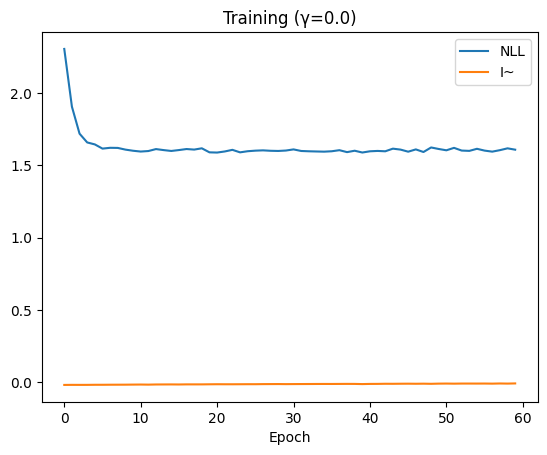


Training FAST (γ=0.3)...
[epoch 1] NLL=3.1303, I~=-3.5102
[epoch 2] NLL=3.4043, I~=-3.2712
[epoch 3] NLL=4.3187, I~=-1.9003
[epoch 4] NLL=4.2299, I~=-1.9294
[epoch 5] NLL=3.6446, I~=-3.2415
[epoch 6] NLL=2.2903, I~=-3.6492
[epoch 7] NLL=2.0025, I~=-3.6026
[epoch 8] NLL=1.8535, I~=-3.5499
[epoch 9] NLL=1.7267, I~=-3.4983
[epoch 10] NLL=1.6839, I~=-3.4465
[epoch 11] NLL=1.6315, I~=-3.3955
[epoch 12] NLL=1.6121, I~=-3.3455
[epoch 13] NLL=1.6267, I~=-3.2959
[epoch 14] NLL=1.6155, I~=-3.2471
[epoch 15] NLL=1.5973, I~=-3.1991
[epoch 16] NLL=1.6000, I~=-3.1517
[epoch 17] NLL=1.6060, I~=-3.1050
[epoch 18] NLL=1.6030, I~=-3.0591
[epoch 19] NLL=1.6085, I~=-3.0139
[epoch 20] NLL=1.5861, I~=-2.9692
[epoch 21] NLL=1.5877, I~=-2.9253
[epoch 22] NLL=1.5892, I~=-2.8820
[epoch 23] NLL=1.6038, I~=-2.8395
[epoch 24] NLL=1.5846, I~=-2.7973
[epoch 25] NLL=1.5939, I~=-2.7561
[epoch 26] NLL=1.5964, I~=-2.7153
[epoch 27] NLL=1.5964, I~=-2.6752
[epoch 28] NLL=1.5980, I~=-2.6356
[epoch 29] NLL=1.5945, I~=-2.59

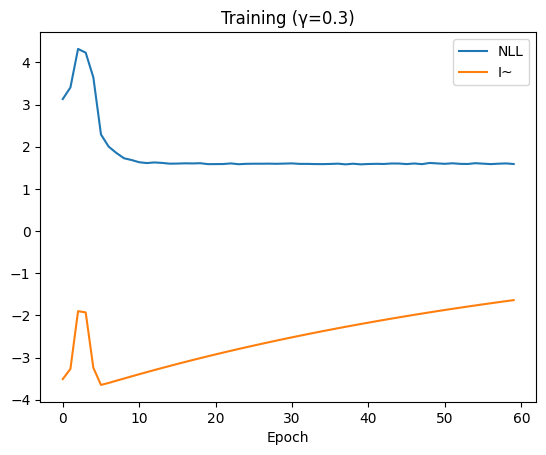

,Baseline,FAST
Brier_all,0.219668,0.207456
C_all,0.564427,0.561406
ΔBrier,0.004059,0.001616
ΔC,0.057108,0.054551
Brier_0,0.221678,0.208256
Brier_1,0.217618,0.206640
C0,0.537419,0.535099
C1,0.594527,0.589650


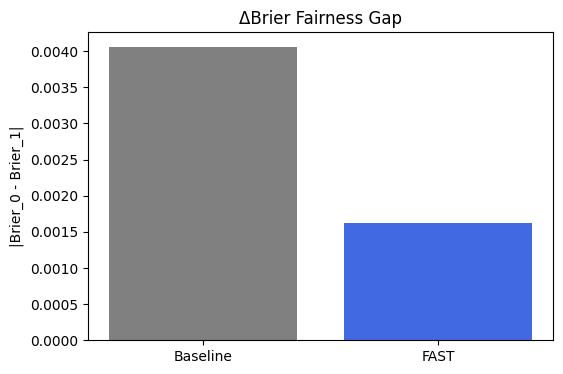

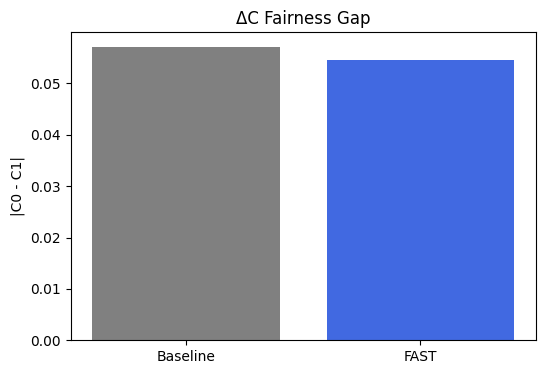

In [4]:
set_seed(SEED)

df = pd.read_csv(DATA_PATH)
feature_cols = [c for c in df.columns if c.startswith("X")]

train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
train_ds = SurvDataset(train_df, feature_cols)
valid_ds = SurvDataset(valid_df, feature_cols)
test_ds  = SurvDataset(test_df,  feature_cols)

# ---- Fit baseline Weibull ----
o, d = train_ds.o, train_ds.d
lambda_hat, rho_hat = fit_baseline(o, d)
print(f"Baseline λ̂={lambda_hat.item():.4f}, ρ̂={rho_hat.item():.4f}")

# ---- Train models ----
K_omega = 2
lr_omega = 1e-5
batch = 512
epochs = 60
lr_theta = 1e-3

print("\nTraining Baseline (γ=0)...")
fnet_base, _ = train_FAST(train_ds, lambda_hat, rho_hat, gamma=0.0, epochs=epochs, K_omega=K_omega,
                          batch=batch, lr_omega=lr_omega, lr_theta=lr_theta)

print("\nTraining FAST (γ=0.3)...")
fnet_fast, _ = train_FAST(train_ds, lambda_hat, rho_hat, gamma=0.3, epochs=epochs, K_omega=K_omega,
                          batch=batch, lr_omega=lr_omega, lr_theta=lr_theta)

# ---- Evaluate on TEST ----
t_eval = torch.tensor(test_df["Y"].median(), dtype=torch.float32)
risk_base = predict_risk(fnet_base, test_ds, lambda_hat, rho_hat, t_eval)
risk_fast = predict_risk(fnet_fast, test_ds, lambda_hat, rho_hat, t_eval)

metrics_base = group_metrics(test_df["Y"].values, test_df["Delta"].values, risk_base, test_df["A"].values, t_eval)
metrics_fast = group_metrics(test_df["Y"].values, test_df["Delta"].values, risk_fast, test_df["A"].values, t_eval)

compare = pd.DataFrame([metrics_base, metrics_fast], index=["Baseline","FAST"]).T
display(compare)

# ---- Visualization ----
plt.figure(figsize=(6,4))
plt.bar(["Baseline","FAST"], [metrics_base["ΔBrier"], metrics_fast["ΔBrier"]], color=["gray","royalblue"])
plt.ylabel("|Brier_0 - Brier_1|"); plt.title("ΔBrier Fairness Gap"); plt.show()

plt.figure(figsize=(6,4))
plt.bar(["Baseline","FAST"], [metrics_base["ΔC"], metrics_fast["ΔC"]], color=["gray","royalblue"])
plt.ylabel("|C0 - C1|"); plt.title("ΔC Fairness Gap"); plt.show()
